In [1]:
import torchrdit
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

from torchrdit.solver import RCWASolver, RDITSolver
from torchrdit.utils import operator_proj, create_material
from tqdm import tqdm, trange

In [2]:
# build hexagonal unit cell
def make_GMRF_hexagonal_mask(radius_var, sim, eta=0.5, beta=100,N=2):
    rsq1 = sim.XO ** 2 + (sim.YO - b / 2) ** 2
    m1 = (rsq1 - (radius_var) ** 2)+0.5
    m1 = operator_proj(m1, eta=eta, beta = beta, num_proj=N)
    rsq2 = sim.XO ** 2 + (sim.YO + b / 2) ** 2
    m2 = (rsq2 - (radius_var) ** 2)+0.5
    m2 = operator_proj(m2, eta=eta, beta = beta, num_proj=N)
    rsq3 = (sim.XO - a / 2) ** 2 + sim.YO ** 2
    m3 = (rsq3 - (radius_var) ** 2)+0.5
    m3 = operator_proj(m3, eta=eta, beta = beta, num_proj=N)
    rsq4 = (sim.XO + a / 2) ** 2 + sim.YO ** 2
    m4 = (rsq4 - (radius_var) ** 2)+0.5
    m4 = operator_proj(m4, eta=eta, beta = beta, num_proj=N)

    mask = m1 + m2 + m3 + m4 - 3
    return mask

In [3]:
def GMRF_simulator(radius, lams, rdit_orders = 10, kdims = 9,is_showinfo = False):
    # units
    um = 1
    nm = 1e-3 * um
    degrees = np.pi / 180

    theta = 0 * degrees
    phi = 0 * degrees

    pte = 1
    ptm = 0

    # device parameters
    n_SiO = 1.4496
    n_SiN = 1.9360
    n_fs = 1.5100

    a = 1150 * nm
    b = a * np.sqrt(3)


    h1 = torch.tensor(230 * nm, dtype=torch.float32)
    h2 = torch.tensor([345 * nm], dtype=torch.float32)

    t1 = torch.tensor([[a/2, -a*np.sqrt(3)/2]], dtype=torch.float32)
    t2 = torch.tensor([[a/2, a*np.sqrt(3)/2]], dtype=torch.float32)

    material_sio = create_material(name='SiO', permittivity=n_SiO**2)
    material_sin = create_material(name='SiN', permittivity=n_SiN**2)
    material_fs = create_material(name='FusedSilica', permittivity=n_fs**2)

    gmrf_sim = RDITSolver(
                rdim = [512, 512],
                kdim = [kdims, kdims],
                lam0 = lams,
                lengthunit = 'um',
                t1 = t1,
                t2 = t2)
    
    gmrf_sim.set_rdit_order(rdit_orders)
    
    gmrf_sim.update_trn_material(trn_material=material_fs)

    gmrf_sim.add_layer(material_name=material_sio,
                  thickness=h1,
                  is_homogeneous=False,
                  is_optimize=True)

    gmrf_sim.add_layer(material_name=material_sin,
                  thickness=h2,
                  is_homogeneous=True,
                  is_optimize=False)

    src = gmrf_sim.add_source(theta = 0 * degrees,
                     phi = 0 * degrees,
                     pte = 1,
                     ptm = 0)

    mask = make_GMRF_hexagonal_mask(radius, gmrf_sim, eta=0.5, beta=100,N=2)
    gmrf_sim.update_er_with_mask(mask=mask, layer_index=0, set_grad = False)

    data = gmrf_sim.solve(src)# Example 1 - GMRF with hexagonal unit cells
    
    return data

# Example 1

In [4]:
# units
um = 1
nm = 1e-3 * um

a = 1150 * nm
b = a * np.sqrt(3)

r0_rdit = torch.tensor(400 * nm)
r0_rdit.requires_grad = True
lam00 = np.array([1540 * nm])

data_rdit = GMRF_simulator(r0_rdit, lam00, rdit_orders=10, kdims = 15, is_showinfo = False)

In [5]:
print(f"The T efficiency (R-DIT) is {data_rdit['TRN'][0] * 100}%")
print(f"The R efficiency (R-DIT) is {data_rdit['REF'][0] * 100}%")

The T efficiency (R-DIT) is 92.23441440607169%
The R efficiency (R-DIT) is 7.765614392644977%


In [6]:
torch.sum(data_rdit['TRN'][0]).backward()

In [7]:
print(f"The derivative of the sum of the transmission efficency with respect to the radius is:")
print(f"\tR-DIT:\t {r0_rdit.grad}")

The derivative of the sum of the transmission efficency with respect to the radius is:
	R-DIT:	 -8.102524757385254


## Frequency Response

This section shows the spectrum of the GMRF by using RCWA and R-DIT.

In [8]:
def plot_spectrum(lamswp0, data_rdit):
    fig_size = (4,3)
    markeverypoints = 4
    nlam = len(lamswp0)
    nref_gmrf_rdit = np.zeros(nlam)
    ntrn_gmrf_rdit = np.zeros(nlam)
    ncon_gmrf_rdit = np.zeros(nlam)

    for ilam, elem in enumerate(lamswp0):
        nref_gmrf_rdit[ilam] = data_rdit['REF'][ilam].detach().clone()
        ntrn_gmrf_rdit[ilam] = data_rdit['TRN'][ilam].detach().clone()
        ncon_gmrf_rdit[ilam] = nref_gmrf_rdit[ilam] + ntrn_gmrf_rdit[ilam]

    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.rcParams.update({'font.size': 10});
    fig_gmrf, ax_gmrf = plt.subplots(figsize=fig_size);
    ax_gmrf.set_xlim(lamswp0[0], lamswp0[-1]);

    ax_gmrf.plot(lamswp0, nref_gmrf_rdit, color='blue', marker='+', linestyle='-', linewidth=1, markersize=4, markevery=markeverypoints, label='Ref-RDIT');
    ax_gmrf.plot(lamswp0, ntrn_gmrf_rdit, color='m', marker='x', linestyle='-', linewidth=1, markersize=4, markevery=markeverypoints, label='Trn-RDIT');

    ax_gmrf.legend();
    ax_gmrf.set_xlabel('Wavelength (um)');
    ax_gmrf.set_ylabel('Transmission/Reflection Efficiency');
    ax_gmrf.set_ylim([0,1.0]);
    ax_gmrf.grid('on');
    
    return fig_gmrf, ax_gmrf 

In [9]:
r1_rdit = torch.tensor(400 * nm)
r1_rdit.requires_grad = False

# Source Parameter
nlam = 200
lam1 = 1530 * nm
lam2 = 1550 * nm
lamswp_gmrf = np.linspace(lam1, lam2, nlam, endpoint=True)

data_gmrfswp_rdit = GMRF_simulator(r1_rdit, lamswp_gmrf, rdit_orders=10, kdims = 11, is_showinfo = False)

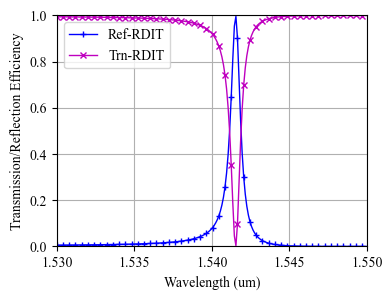

In [10]:
plot_spectrum(lamswp0=lamswp_gmrf, data_rdit=data_gmrfswp_rdit);

## Gradient Descent

Next step, we are going to optimize the device to our goal. Assuming we want the peaks of the resonance at the wavelength $1537~nm$, so we can implement the gradient descent by minimizing the transmission efficiency.

In [11]:
# ================== Basic Parameters ==================
um = 1
nm = 1e-3 * um
degrees = np.pi / 180
lam_opt = np.array([1537 * nm])

theta = 0 * degrees
phi = 0 * degrees

pte = 1
ptm = 0

# device parameters
n_SiO = 1.4496
n_SiN = 1.9360
n_fs = 1.5100

a = 1150 * nm
b = a * np.sqrt(3)

h1 = torch.tensor(230 * nm, dtype=torch.float32)
h2 = torch.tensor([345 * nm], dtype=torch.float32)

t1 = torch.tensor([[a/2, -a*np.sqrt(3)/2]], dtype=torch.float32)
t2 = torch.tensor([[a/2, a*np.sqrt(3)/2]], dtype=torch.float32)

material_sio = create_material(name='SiO', permittivity=n_SiO**2)
material_sin = create_material(name='SiN', permittivity=n_SiN**2)
material_fs = create_material(name='FusedSilica', permittivity=n_fs**2)

r_dit_order = 10
kdims = 9
    
# ================== Basic Parameters ==================

# ================== Solver Intialization ==================

gmrf_sim_rdit = RDITSolver(
            rdim = [512, 512],
            kdim = [kdims, kdims],
            lam0 = lam_opt,
            lengthunit = 'um',
            materiallist = [material_sio, material_sin, material_fs],
            t1 = t1,
            t2 = t2)

gmrf_sim_rdit.set_rdit_order(r_dit_order)

gmrf_sim_rdit.update_trn_material(trn_material='FusedSilica')

gmrf_sim_rdit.add_layer(material_name='SiO',
              thickness=h1,
              is_homogeneous=False,
              is_optimize=True)

gmrf_sim_rdit.add_layer(material_name='SiN',
              thickness=h2,
              is_homogeneous=True,
              is_optimize=False)

src_rdit = gmrf_sim_rdit.add_source(theta = 0 * degrees,
                 phi = 0 * degrees,
                 pte = 1,
                 ptm = 0)

# ================== Solver Intialization ==================

In [12]:
def objective_GMRF(dev, src, radius):

    mask = make_GMRF_hexagonal_mask(radius, dev, eta=0.5, beta=100, N=2)

    dev.update_er_with_mask(mask=mask, layer_index=0, set_grad = False)
    
    data = dev.solve(src)
    
    return data['TRN'][0] * 1e2 # return transimission efficiency as FoM to be minimized

In [13]:
grads_rdit = {}

def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [14]:
from torch.utils.tensorboard import SummaryWriter

r2_rdit_opt = torch.tensor(400 * nm)
r2_rdit_opt.requires_grad = True

# learning rate
lr_rate_rdit = 5e-3

# Define the optimizer
optimizer_rdit = torch.optim.Adam([r2_rdit_opt,], lr=lr_rate_rdit, eps=1e-2)

# Define the scheduler
scheduler_rdit = torch.optim.lr_scheduler.MultiStepLR(optimizer_rdit, milestones=[50, 100, 150], gamma=0.9)

writer = SummaryWriter(comment="_RDIT")

# Number of epochs in the optimization
EPOCH = 200

# ======================= RDIT Optimization =========================

t1 = time.perf_counter()

for epoch in trange(EPOCH):
    tic = time.time()
    optimizer_rdit.zero_grad()
    loss_rdit = objective_GMRF(gmrf_sim_rdit, src_rdit, r2_rdit_opt)
    loss_rdit.backward()
    
    t_elapsed = time.time() - tic
    writer.add_scalar("RDIT/Loss", loss_rdit, epoch)
    # writer.add_scalar("Train/lr", optimizer.param_groups[0]['lr'], epoch)
    writer.add_scalar("RDIT/Radius", r2_rdit_opt, epoch)
    writer.add_scalar("RDIT/Radius_grad", r2_rdit_opt.grad, epoch)
    writer.add_scalar("RDIT/Time", t_elapsed, epoch)
    optimizer_rdit.step()
    scheduler_rdit.step()
    
t2 = time.perf_counter()
print(f"RDIT optimization time = {(t2 - t1) * 1000} ms")

# ======================= RDIT Optimization =========================
    
        
writer.flush()
writer.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [16:01<00:00,  4.81s/it]

RDIT optimization time = 961934.700832935 ms


In [15]:
print(f"The optimal radius (RDIT) is {r2_rdit_opt}")

The optimal radius (RDIT) is 0.4485945701599121


In [16]:
# Source Parameter
nlam = 200
lam1 = 1530 * nm
lam2 = 1550 * nm
lamswp_gmrf = np.linspace(lam1, lam2, nlam, endpoint=True)

# Simulate for the optimized the performance 
data_optimized_rdit = GMRF_simulator(r2_rdit_opt.detach(), lamswp_gmrf, rdit_orders=10, kdims = 9, is_showinfo = True)

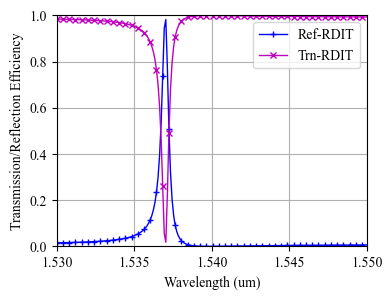

In [17]:
plot_spectrum(lamswp0=lamswp_gmrf, data_rdit=data_optimized_rdit);

In [18]:
def plot_spectrum_compare_opt(lamswp0, data_org, data_opt):
    fig_size = (3,2)
    markeverypoints = 4
    nlam = len(lamswp0)
    nref_gmrf_org = np.zeros(nlam)
    ntrn_gmrf_org = np.zeros(nlam)
    ncon_gmrf_org = np.zeros(nlam)

    nref_gmrf_opt = np.zeros(nlam)
    ntrn_gmrf_opt = np.zeros(nlam)
    ncon_gmrf_opt = np.zeros(nlam)

    for ilam, elem in enumerate(lamswp0):

        nref_gmrf_org[ilam] = data_org['REF'][ilam].detach().clone()
        ntrn_gmrf_org[ilam] = data_org['TRN'][ilam].detach().clone()
        ncon_gmrf_org[ilam] = nref_gmrf_org[ilam] + ntrn_gmrf_org[ilam]

        nref_gmrf_opt[ilam] = data_opt['REF'][ilam].detach().clone()
        ntrn_gmrf_opt[ilam] = data_opt['TRN'][ilam].detach().clone()
        ncon_gmrf_opt[ilam] = nref_gmrf_opt[ilam] + ntrn_gmrf_opt[ilam]

    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.rcParams.update({'font.size': 10});
    # plt.rcParams["figure.dpi"] = 300
    fig_gmrf, ax_gmrf = plt.subplots(figsize=fig_size);
    ax_gmrf.set_position = ([0, 0, 0.8, 1])
    ax_gmrf.set_xlim(lamswp0[0], lamswp0[-1]);
    ax_gmrf.plot(lamswp0, nref_gmrf_org, color='red', marker='', linestyle='-.', linewidth=1, markersize=4, markevery=markeverypoints, label='R-Init');
    ax_gmrf.plot(lamswp0, ntrn_gmrf_org, color='green', marker='', linestyle='-', linewidth=1, markersize=8, markevery=markeverypoints, label='T-Init');
    # ax_gmrf.plot(lamswp0, ncon_gmrf_rcwa, color='brown', marker='', linestyle=':', linewidth=2, markersize=8, label='Con-RCWA')

    ax_gmrf.plot(lamswp0, nref_gmrf_opt, color='blue', marker='x', linestyle='-', linewidth=1, markersize=4, markevery=markeverypoints, label='R-Opt');
    ax_gmrf.plot(lamswp0, ntrn_gmrf_opt, color='m', marker='', linestyle='--', linewidth=1, markersize=4, markevery=markeverypoints, label='T-Opt');
    # ax_gmrf.plot(lamswp0, ncon_gmrf_rdit, color='black', marker='1', linestyle='', linewidth=2, markersize=4, label='Con-RDIT')

    ax_gmrf.legend(loc='center left', bbox_to_anchor=(0.6,0.5), frameon=False);
    # ax_gmrf.legend(loc='center right');
    ax_gmrf.set_xlabel('Wavelength [um]');
    ax_gmrf.set_ylabel('T/R');
    ax_gmrf.set_ylim([0,1.0]);
    # ax_gmrf.grid('on');
    
    return fig_gmrf, ax_gmrf

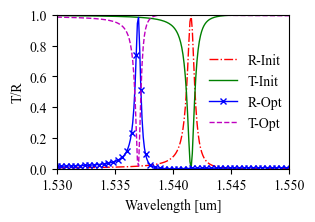

In [19]:
plot_spectrum_compare_opt(lamswp0=lamswp_gmrf, data_org=data_gmrfswp_rdit, data_opt=data_optimized_rdit);